In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, f1_score, classification_report
from collections import Counter

In [2]:
df = pd.read_csv('RT_IOT2022.csv')
df = df.copy()

In [3]:
df['Attack_type'].value_counts()

Attack_type
DOS_SYN_Hping                 94659
Alexa                         86842
Thing_Speak                    8108
ARP_poisioning                 7750
MQTT_Publish                   4146
NMAP_UDP_SCAN                  2590
NMAP_XMAS_TREE_SCAN            2010
NMAP_OS_DETECTION              2000
NMAP_TCP_scan                  1002
DDOS_Slowloris                  534
Wipro_bulb                      253
Metasploit_Brute_Force_SSH       37
NMAP_FIN_SCAN                    28
Name: count, dtype: int64

In [4]:
df.shape

(209959, 84)

In [5]:
df_drop = []

df_drop = [col for col in df.columns if col.endswith(('.min', '.max', '_min', '_max'))]

df_drop += ['id.orig_p', 'id.resp_p', 'proto', 'service']

df = df.drop(df_drop, axis=1, errors='ignore')

In [6]:
# Find proportion of the most frequent value in each column
dominant_ratio = df.apply(lambda x: x.value_counts(normalize=True).max())

# Filter columns where the most frequent value occurs in ≥90% of the rows
high_dominance_cols = dominant_ratio[dominant_ratio >= 0.9]

print(high_dominance_cols)


fwd_URG_flag_count     0.990446
bwd_URG_flag_count     1.000000
flow_CWR_flag_count    0.999662
flow_ECE_flag_count    0.999657
active.std             0.913421
idle.std               0.993865
dtype: float64


In [7]:
df_drop = high_dominance_cols.index.tolist()

df = df.drop(df_drop, axis=1, errors='ignore')

df.shape

(209959, 54)

In [8]:
# Compute correlation matrix on numeric columns
corr_matrix = df.drop('Attack_type', axis=1).corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation > 0.95
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.95)]

print(f"Dropping {len(to_drop_corr)} highly correlated features:")
print(to_drop_corr)

# Drop them
df = df.drop(columns=to_drop_corr)

Dropping 18 highly correlated features:
['fwd_data_pkts_tot', 'bwd_pkts_per_sec', 'flow_pkts_per_sec', 'fwd_header_size_tot', 'bwd_header_size_tot', 'fwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_pkts_payload.tot', 'bwd_pkts_payload.tot', 'flow_pkts_payload.tot', 'fwd_iat.tot', 'flow_iat.tot', 'flow_iat.std', 'payload_bytes_per_second', 'bwd_bulk_bytes', 'bwd_bulk_packets', 'idle.tot', 'idle.avg']


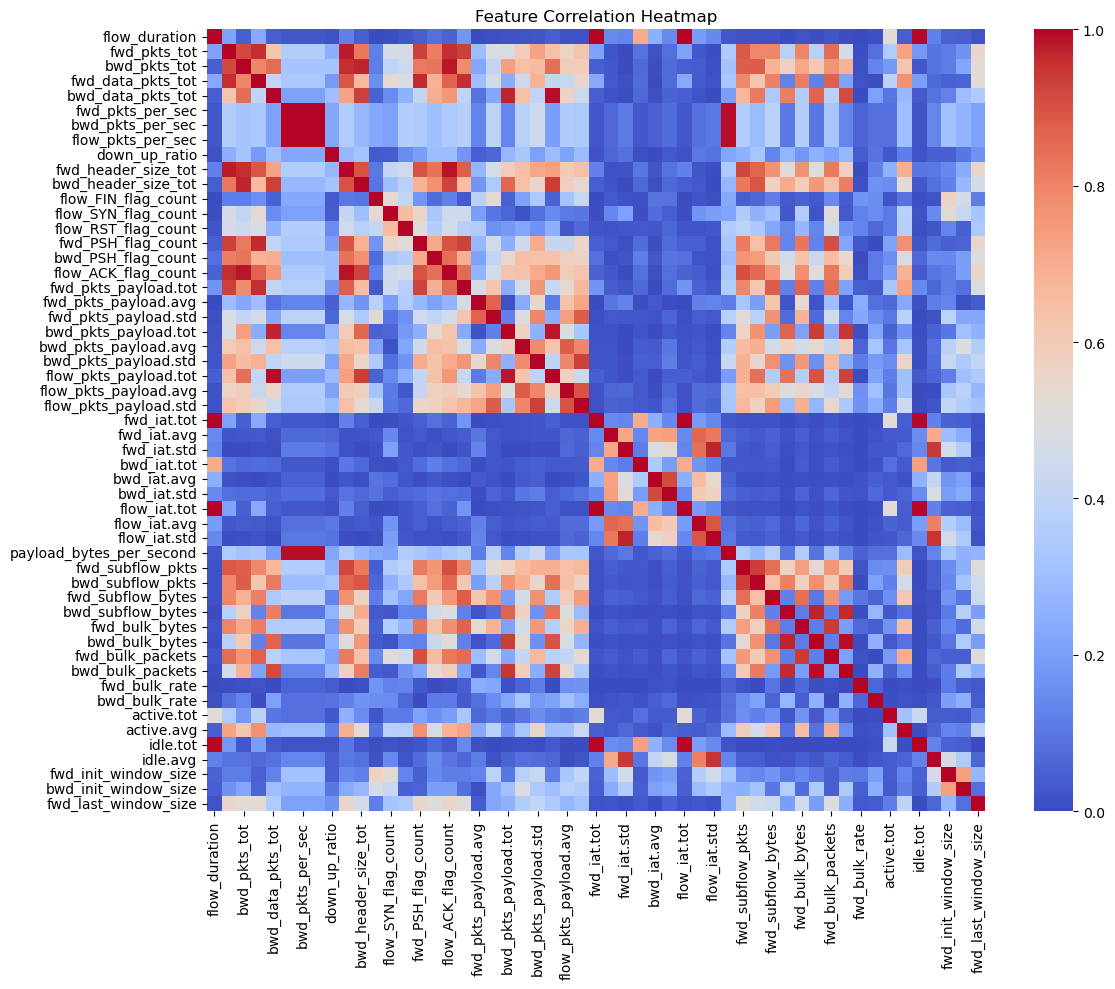

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', vmax=1.0, vmin=0.0)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [19]:
# Drop based on feature importance from models 
features_to_drop = [
    'fwd_iat.std',
    'active.avg',
    'bwd_subflow_pkts',
    'bwd_pkts_tot',
    'bwd_pkts_payload.avg',
    'flow_pkts_payload.std'
]

# df = df.drop(columns=features_to_drop)
df.shape

(209959, 36)

In [21]:
non_attacks = ['Alexa', 'Wipro_bulb', 'MQTT_Publish' , 'Thing_Speak']
df['Attack_label'] = df['Attack_type'].apply(lambda x: 0 if x in non_attacks else 1)
print(df['Attack_label'].value_counts())
df.shape

Attack_label
1    110610
0     99349
Name: count, dtype: int64


(209959, 37)

In [23]:
df.head()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,down_up_ratio,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,bwd_PSH_flag_count,...,fwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.tot,active.avg,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,Attack_type,Attack_label
0,0.005875,1,1,1,170.209561,1.000000,0,0,0,0,...,0.0,0.000000,0.000000,5.875111e+03,5.875111e+03,0,0,0,Alexa,0
1,7.807541,159,144,38,20.364926,0.905660,0,0,0,23,...,62.5,10096.717546,33346.967364,7.807541e+06,7.807541e+06,11890,3216,11890,Alexa,0
2,0.216894,7,7,2,32.273807,1.000000,3,2,0,2,...,0.0,0.000000,0.000000,3.060679e+05,3.060679e+05,29200,29200,1065,Alexa,0
3,0.014496,10,10,10,689.841286,1.000000,0,0,0,0,...,0.0,0.000000,0.000000,1.449609e+04,1.449609e+04,0,0,0,Alexa,0
4,8.797776,158,176,45,17.959084,1.113924,0,0,0,38,...,124.0,10251.481385,32467.560574,8.797776e+06,8.797776e+06,11890,3220,11890,Alexa,0


In [25]:
# Use exactly the same df you finished cleaning above
feature_cols = df.drop(columns=['Attack_type', 'Attack_label']).columns
X_full = df[feature_cols].copy()

# Standardise (very important for distance-based methods)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

Why scale? K-Means, hierarchical clustering, DBSCAN and distance-based anomaly detectors all use Euclidean (or related) distances; variables on larger numeric scales would dominate otherwise.

A high-dimensional space (∼34 numeric features here) is fine for the algorithms, but (a) visualising clusters, and (b) speeding up DBSCAN both benefit from working in a lower sub-space.

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=0)     # keep 95 % variance
X_pca = pca.fit_transform(X_scaled)
print(f"PCA components kept: {pca.n_components_}")

PCA components kept: 17


In [31]:
X_run   = X_scaled      # for “serious” clustering
X_plot  = X_pca         # for quick visualisations

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_range     = range(2, 11)
inertias    = []
sils        = []
all_labels  = []               # ← create it here

for k in k_range:
    km = KMeans(n_clusters=k, n_init='auto', random_state=0)
    labels = km.fit_predict(X_run)

    inertias.append(km.inertia_)
    sils.append(
        silhouette_score(X_run, labels, sample_size=10_000, random_state=0)
    )
    all_labels.append(labels)      # ← store labels for later metrics

print(len(all_labels), "label arrays stored")
print([len(l) for l in all_labels] if isinstance(all_labels, list) else [len(v) for v in all_labels.values()])

9 label arrays stored
[209959, 209959, 209959, 209959, 209959, 209959, 209959, 209959, 209959]


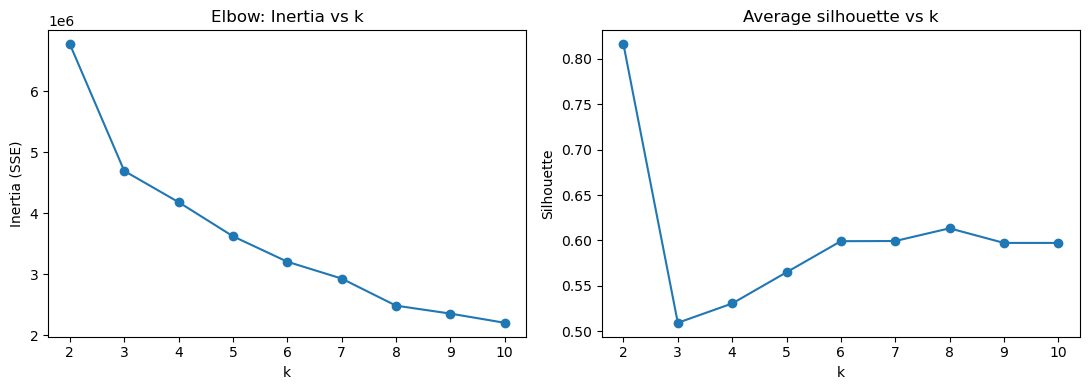

In [35]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(11, 4))

ax[0].plot(k_range, inertias, marker='o')
ax[0].set_title("Elbow: Inertia vs k")
ax[0].set_xlabel("k");  ax[0].set_ylabel("Inertia (SSE)")

ax[1].plot(k_range, sils, marker='o')
ax[1].set_title("Average silhouette vs k")
ax[1].set_xlabel("k");  ax[1].set_ylabel("Silhouette")

plt.tight_layout();  plt.show()

	•	Elbow: look for the k where the inertia curve bends sharply and flattens—diminishing returns beyond that point.
	•	Silhouette: higher is better (max = 1).  For many real-world datasets:
	•	≥ 0.50 — very clear separation
	•	0.25 - 0.50 — usable but overlaps exist
	•	< 0.25 — clustering probably not meaningful

Rule-of-thumb: pick the smallest k that is near the elbow and whose silhouette hasn’t dropped noticeably.

In [37]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

chs, dbs = [], []
for k, lbl in zip(k_range, all_labels): 
    chs.append(calinski_harabasz_score(X_run, lbl))
    dbs.append(davies_bouldin_score(X_run, lbl))

    k  silhouette  calinski_harabasz  davies_bouldin
0   2       0.816          17978.082           0.216
1   3       0.509          59367.274           0.772
2   4       0.531          52983.293           0.802
3   5       0.565          53965.024           1.102
4   6       0.599          54245.297           1.042
5   7       0.599          52757.285           0.930
6   8       0.613          58638.603           0.965
7   9       0.597          55593.481           1.052
8  10       0.597          54388.281           0.943


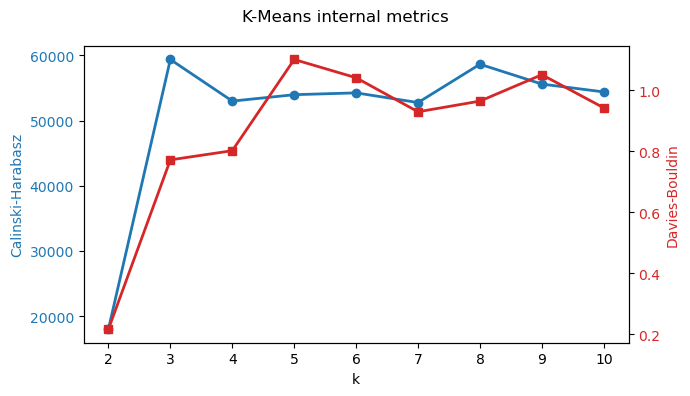

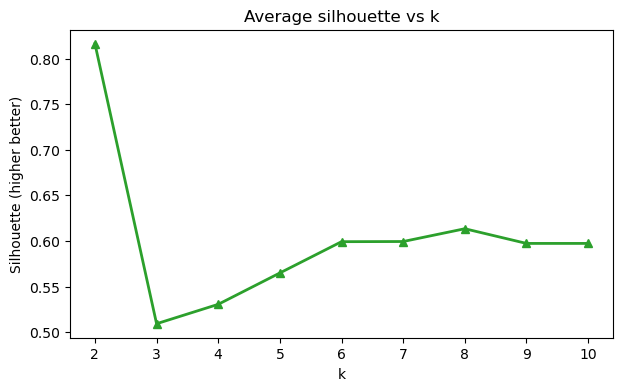

In [70]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Put all metrics into one tidy frame ----------------------------
metrics = pd.DataFrame({
    "k": list(k_range),
    "silhouette": sils,
    "calinski_harabasz": chs,
    "davies_bouldin": dbs
})

print(metrics.round(3))        # nice to eyeball exact numbers

# --- Dual-axis plot for CH & DB on one figure -----------------------
fig, ax1 = plt.subplots(figsize=(7,4))

ax1.plot(metrics["k"], metrics["calinski_harabasz"],
         marker="o", label="CH index (higher better)", lw=2)
ax1.set_xlabel("k")
ax1.set_ylabel("Calinski-Harabasz", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(metrics["k"], metrics["davies_bouldin"],
         marker="s", label="DB index (lower better)",
         lw=2, color="tab:red")
ax2.set_ylabel("Davies-Bouldin", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

fig.suptitle("K-Means internal metrics")
fig.tight_layout()
plt.show()

# --- Optional: overlay silhouette on a second figure ---------------
plt.figure(figsize=(7,4))
plt.plot(metrics["k"], metrics["silhouette"],
         marker="^", lw=2, color="tab:green")
plt.title("Average silhouette vs k")
plt.xlabel("k"); plt.ylabel("Silhouette (higher better)")
plt.show()